## Data Assessment of Waterflow Historical Data

**Metadata Summary**  
- 📅 **Date of Retrieval:** JULY 1, 2025  
- 🌐 **Source of Data:** LGU San Jacinto Treasury Records
- 📄 **License/Permission:**  
- 🧑‍💼 **Prepared by:** MARK JUNE E. ALMOJUELA

# Overview of the Datasets

In [81]:
def check_dataset_availability(base_path: str = "../../dataset/raw/") -> dict:
    """
    Check and report the availability of water consumption dataset files.
    
    This function scans the specified directory and its subdirectories to:
    1. Identify all available years of data
    2. Count and list all CSV files for each year
    3. Report any potential issues with file structure or access
    
    Args:
        base_path (str): Path to the root directory containing year-based subdirectories.
                        Defaults to "../../dataset/raw/"
    
    Returns:
        dict: A dictionary containing the scan results with the following structure:
            {
                'years_available': [list of year strings],
                'file_counts': {year: count},
                'file_lists': {year: [list of filenames]},
                'issues': [list of any issues found]
            }
    
    Example:
        >>> results = check_dataset_availability()
        >>> print(f"Found data for years: {results['years_available']}")
        >>> print(f"File counts: {results['file_counts']}")
    """
    import os
    from pathlib import Path
    from typing import List, Dict, Union
    
    results = {
        'years_available': [],
        'file_counts': {},
        'file_lists': {},
        'issues': []
    }
    
    try:
        # Convert to Path object for better path handling
        data_dir = Path(base_path)
        
        # Check if the directory exists
        if not data_dir.exists():
            raise FileNotFoundError(f"Directory not found: {data_dir.absolute()}")
        
        if not data_dir.is_dir():
            raise NotADirectoryError(f"Path is not a directory: {data_dir.absolute()}")
        
        # Find all year directories
        year_dirs = [d for d in data_dir.iterdir() if d.is_dir() and d.name.isdigit()]
        year_dirs.sort()  # Sort years chronologically
        
        if not year_dirs:
            results['issues'].append("No year directories found in the specified path")
            return results
        
        print("🔍 Dataset Availability Report")
        print("=" * 50)
        
        for year_dir in year_dirs:
            year = year_dir.name
            results['years_available'].append(year)
            
            try:
                # Find all CSV files in the year directory
                csv_files = sorted([f.name for f in year_dir.glob('*.csv')])
                file_count = len(csv_files)
                
                results['file_counts'][year] = file_count
                results['file_lists'][year] = csv_files
                
                # Print summary
                print(f"\n📅 Year: {year}")
                print(f"   📂 Directory: {year_dir.absolute()}")
                print(f"   📊 Files found: {file_count}")
                
                # List files in a compact format
                if csv_files:
                    print("   📋 Files:")
                    # Group files by prefix (e.g., month names)
                    file_groups = {}
                    for f in csv_files:
                        prefix = f.split('_')[0]
                        if prefix not in file_groups:
                            file_groups[prefix] = []
                        file_groups[prefix].append(f)
                    
                    # Print grouped files
                    for prefix, files in file_groups.items():
                        if len(files) > 3:
                            print(f"     - {prefix}*: {len(files)} files")
                        else:
                            for f in files:
                                print(f"     - {f}")
                else:
                    results['issues'].append(f"No CSV files found in {year_dir.absolute()}")
                    print("   ⚠️  No CSV files found")
            
            except PermissionError:
                msg = f"Permission denied accessing {year_dir.absolute()}"
                results['issues'].append(msg)
                print(f"   ⚠️  {msg}")
            except Exception as e:
                msg = f"Error processing {year_dir.absolute()}: {str(e)}"
                results['issues'].append(msg)
                print(f"   ❌ {msg}")
        
        print("\n" + "=" * 50)
        print(f"✅ Scan complete. Found data for {len(results['years_available'])} year(s)")
        
        # Print summary
        if results['years_available']:
            print("\n📊 Summary of available data:")
            for year in sorted(results['years_available']):
                print(f"   {year}: {results['file_counts'].get(year, 0)} files")
        
        if results['issues']:
            print("\n⚠️  Issues found:")
            for issue in results['issues']:
                print(f"   • {issue}")
        
        return results
    
    except Exception as e:
        error_msg = f"Error scanning dataset directory: {str(e)}"
        results['issues'].append(error_msg)
        print(f"\n❌ {error_msg}")
        return results

year = '2022'
results = check_dataset_availability(f"../../dataset/raw/{year}/compiled")

In [19]:
"""
Data Assessment and Analysis Script

This script performs an initial data quality assessment on water consumption CSV files.
It analyzes data patterns, identifies duplicates, and provides statistical summaries
for water meter reading data organized by year and month.

Author: [Your Name/Organization]
Date: [Last Updated]
"""

import os
import pandas as pd
from datetime import datetime

# ANSI color codes for terminal output formatting
class TerminalColors:
    """ANSI escape codes for terminal text formatting"""
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    RESET = "\033[0m"
    BOLD = "\033[1m"

def extract_date(filename):
    """
    Extracts date information from filename.
    
    Args:
        filename (str): Name of the file in format 'MMM_YYYY.csv' (e.g., 'JAN_2023.csv')
        
    Returns:
        datetime: Parsed date object or datetime.max if parsing fails
    """
    try:
        base = os.path.splitext(filename)[0]
        month_str = base[:3].upper()  # First 3 chars for month abbreviation
        year_str = base[-4:]          # Last 4 chars for year
        return datetime.strptime(f"{month_str} {year_str}", "%b %Y")
    except Exception as e:
        print(f"Warning: Could not parse date from {filename}: {e}")
        return datetime.max  # Put problematic files at the end

# Configure pandas display options for better console output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def main():
    """
    Main function to execute the data assessment workflow.
    """
    # User input for target year
    year = input("📅 Enter year to analyze: ")
    data_dir_path = f"../../dataset/raw/{year}/compiled/"

    # Validate directory exists
    if not os.path.exists(data_dir_path):
        print(f"{TerminalColors.FAIL}Error: Directory not found: {data_dir_path}{TerminalColors.RESET}")
        return

    # Initialize data quality metrics
    quality_metrics = {
        'files_processed': 0,
        'total_records': 0,
        'duplicate_records': 0,
        'missing_values': {}
    }

    # Process each CSV file in the directory
    csv_files = [f for f in os.listdir(data_dir_path) if f.endswith(".csv")]
    csv_files.sort(key=extract_date)  # Sort by date extracted from filename

    for csv_file in csv_files:
        quality_metrics['files_processed'] += 1
        print(f"\n{TerminalColors.BOLD}{TerminalColors.OKGREEN}"
              f"📂 Processing File: {csv_file}{TerminalColors.RESET}")
        
        try:
            # Load and analyze data
            file_path = os.path.join(data_dir_path, csv_file)
            df = pd.read_csv(file_path, encoding='latin-1')
            quality_metrics['total_records'] += len(df)

            # Display basic file information
            print(f"{TerminalColors.OKBLUE}📌 Shape:{TerminalColors.RESET} {df.shape}")
            print(f"{TerminalColors.OKBLUE}🧾 Columns:{TerminalColors.RESET} {df.columns.tolist()}")
            
            # Data quality analysis
            missing_values = df.isnull().sum()
            print(f"{TerminalColors.OKBLUE}❓ Missing Values:{TerminalColors.RESET}\n{missing_values}")
            
            # Update missing values metrics
            for col, count in missing_values.items():
                if count > 0:
                    if col not in quality_metrics['missing_values']:
                        quality_metrics['missing_values'][col] = 0
                    quality_metrics['missing_values'][col] += count

            # Duplicate analysis
            name_field = "Consumer's Name" if "Consumer's Name" in df.columns else 'Account Name'
            duplicates = {
                'records': df.duplicated().sum(),
                'consumer_names': df.duplicated(name_field).sum(),
                'control_numbers': df.duplicated('Control Number').sum(),
                'serial_numbers': df.duplicated('Water Meter Serial #').sum(),
                'installations': df.duplicated([
                    'Address', 
                    "Consumer's Name", 
                    'Control Number', 
                    'Water Meter Serial #'
                ]).sum()
            }

            quality_metrics['duplicate_records'] += duplicates['records']

            # Print duplicate analysis
            for metric, count in duplicates.items():
                metric_name = ' '.join(word.capitalize() for word in metric.split('_'))
                print(f"{TerminalColors.WARNING}Duplicated {metric_name}:{TerminalColors.RESET} {count}")

            # Display data sample and statistics
            print(f"\n{TerminalColors.OKBLUE}📊 Descriptive Statistics:{TerminalColors.RESET}")
            print(df.describe(include='all'))
            
            print(f"\n{TerminalColors.OKBLUE}👀 Sample Data (First 5 Rows):{TerminalColors.RESET}")
            print(df.head())
            
            print(f"\n{TerminalColors.OKBLUE}🧠 Data Types and Memory Usage:{TerminalColors.RESET}")
            df.info()

        except Exception as e:
            print(f"{TerminalColors.FAIL}Error processing {csv_file}: {str(e)}{TerminalColors.RESET}")

    # Print summary report
    print(f"\n{TerminalColors.HEADER}{TerminalColors.BOLD}"
          f"📊 Data Quality Assessment Summary for {year}{TerminalColors.RESET}")
    print(f"• Files Processed: {quality_metrics['files_processed']}")
    print(f"• Total Records: {quality_metrics['total_records']:,}")
    print(f"• Total Duplicate Records: {quality_metrics['duplicate_records']:,}")
    
    if quality_metrics['missing_values']:
        print("\nMissing Values by Column:")
        for col, count in quality_metrics['missing_values'].items():
            print(f"  • {col}: {count:,}")

if __name__ == "__main__":
    main()


📂 Processing File: JAN_2023.csv
📌 Shape: (2011, 7)
🧾 Columns: ['Control Number', "Consumer's Name", 'Address', 'Previous', 'Present', 'Cons.', 'Amount']
❓ Missing Values:
Control Number       0
Consumer's Name      0
Address              0
Previous            64
Present             77
Cons.              188
Amount             422
dtype: int64
Error processing JAN_2023.csv: Index(['Water Meter Serial #'], dtype='object')

📂 Processing File: FEB_2023.csv
📌 Shape: (2015, 7)
🧾 Columns: ['Control Number', "Consumer's Name", 'Address', 'Previous', 'Present', 'Cons.', 'Amount']
❓ Missing Values:
Control Number       0
Consumer's Name      0
Address              0
Previous            71
Present             63
Cons.              163
Amount             400
dtype: int64
Error processing FEB_2023.csv: Index(['Water Meter Serial #'], dtype='object')

📂 Processing File: MAR_2023.csv
📌 Shape: (2016, 6)
🧾 Columns: ['Control Number', 'Account Name', 'Service Address', 'Previous Reading', 'Present Read

# Duplicate value anomaly

🔍 Analyzing duplicate anomalies for Consumer's Name in 2020...

📊 Duplicate Analysis Summary:
--------------------------------------------------
Total months processed: 12
Total duplicate records found: 1,671
Month with most duplicates: APR (149 duplicates)


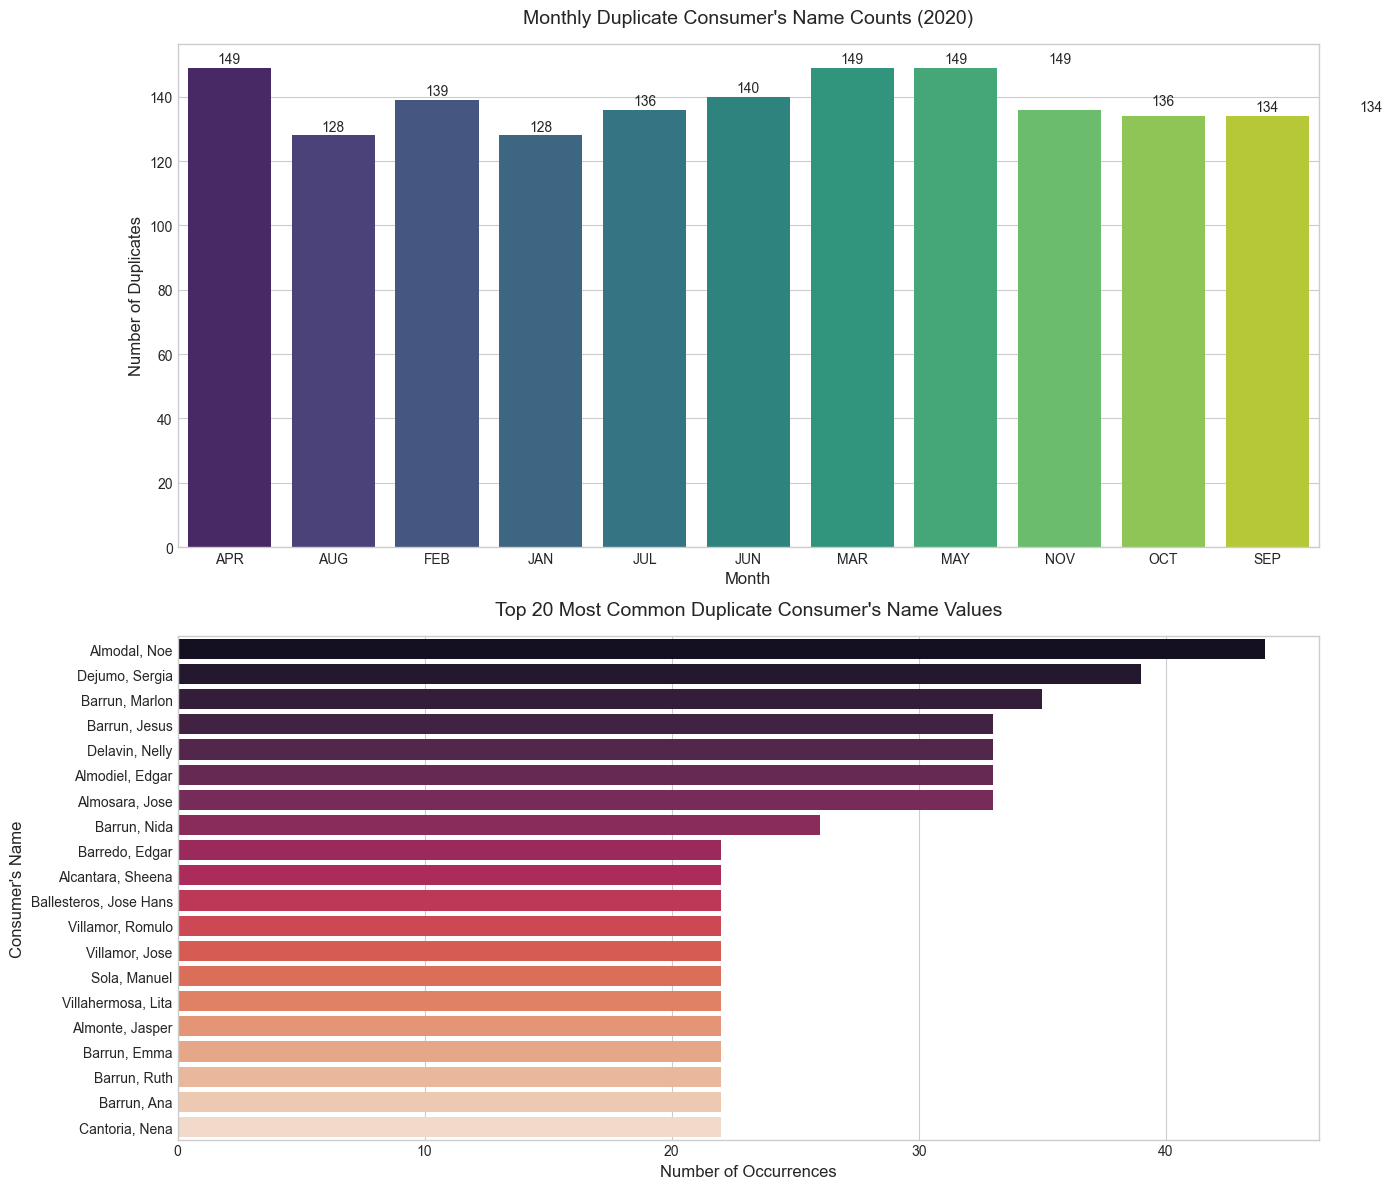


🔎 Sample of duplicate records:
Sample from APR (month with most duplicates):


,Control Number,Consumer's Name,Address,Water Meter Serial #,Previous,Present,Cons.,Amount,Connection Status
680,501114.0,"Albaño, Emie",Don Juan St.,NaN,3776,3776,0,0,Disconnected
1474,501385.0,"Albaño, Emie",Moyot St.,NaN,837,837,0,0,Connected
302,501201.0,"Alcantara, Sheena",Bailon St.,28949,1963,1971,8,80,Connected
1399,501400.0,"Alcantara, Sheena",Lique St.,14Y125171,758,777,19,190,Connected
565,500994.0,"Almiñe, Edwin",Bartolabac St.,027452-02,13,13,0,0,Disconnected


In [25]:
def analyze_duplicate_anomalies(year: str, column_name: str) -> None:
    """
    Analyze and visualize duplicate anomalies for a specific column across all months of a year.
    
    This function:
    1. Processes all monthly CSV files for the given year
    2. Identifies and counts duplicate values in the specified column
    3. Generates visualizations showing duplicate trends
    4. Provides detailed analysis of duplicate records
    
    Args:
        year (str): The year to analyze (e.g., "2020")
        column_name (str): The column name to check for duplicates (e.g., "Water Meter Serial #")
    
    Returns:
        None: Displays visualizations and prints analysis
    """
    import os
    import pandas as pd
    from datetime import datetime
    import matplotlib.pyplot as plt
    import seaborn as sns
    from typing import Dict, List, Tuple
    
    def get_monthly_duplicates(year: str, column_name: str) -> Tuple[Dict[str, pd.DataFrame], List[str], List[int]]:
        """
        Process monthly data and find duplicates.
        
        Args:
            year: Year to process
            column_name: Column to check for duplicates
            
        Returns:
            Tuple containing:
                - Dictionary of {month: DataFrame of duplicates}
                - List of month names
                - List of duplicate counts per month
        """
        data_dir_path = f"../../dataset/raw/{year}/compiled"
        all_duplicates = {}
        months = []
        duplicate_counts = []
        
        # Get all monthly files
        monthly_files = [f for f in os.listdir(data_dir_path) 
                        if f.endswith('.csv') and f.startswith(tuple([m.upper() for m in ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
                                                                                        'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']]))]
        
        for month_file in sorted(monthly_files):
            try:
                # Extract month name
                month = month_file[:3].upper()
                months.append(month)
                
                # Read and process data
                df = pd.read_csv(os.path.join(data_dir_path, month_file), encoding='latin-1')
                
                # Clean and prepare data
                df_clean = df.dropna(subset=[column_name])
                
                # Find all duplicates (including first occurrence)
                duplicates_mask = df_clean[column_name].duplicated(keep=False)
                duplicates_df = df_clean[duplicates_mask].sort_values(column_name)
                
                # Store results
                all_duplicates[month] = duplicates_df
                duplicate_counts.append(len(duplicates_df))
                
            except Exception as e:
                print(f"Error processing {month_file}: {str(e)}")
                continue
                
        return all_duplicates, months, duplicate_counts
    
    def plot_duplicate_analysis(months: List[str], duplicate_counts: List[int], 
                          all_duplicates: Dict[str, pd.DataFrame], column_name: str, year: str) -> None:
        """
        Generate visualizations for duplicate analysis.
        
        Args:
            months: List of month abbreviations
            duplicate_counts: List of duplicate counts per month
            all_duplicates: Dictionary of duplicate DataFrames
            column_name: Column being analyzed
            year: Year being analyzed
        """
        # Set up the plotting style
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        # Plot 1: Monthly Duplicate Trends
        sns.barplot(x=months, y=duplicate_counts, hue=months, 
                    palette='viridis', ax=ax1, legend=False)
        ax1.set_title(f'Monthly Duplicate {column_name} Counts ({year})', fontsize=14, pad=15)
        ax1.set_xlabel('Month', fontsize=12)
        ax1.set_ylabel('Number of Duplicates', fontsize=12)
        
        # Add value labels
        for i, v in enumerate(duplicate_counts):
            ax1.text(i, v + 0.5, str(v), ha='center', va='bottom')
        
        # Plot 2: Top 20 Most Common Duplicates
        all_dups_combined = pd.concat(all_duplicates.values())
        top_duplicates = all_dups_combined[column_name].value_counts().head(20)
        
        sns.barplot(x=top_duplicates.values, y=top_duplicates.index, 
                    hue=top_duplicates.index, palette='rocket', ax=ax2, legend=False)
        ax2.set_title(f'Top 20 Most Common Duplicate {column_name} Values', fontsize=14, pad=15)
        ax2.set_xlabel('Number of Occurrences', fontsize=12)
        ax2.set_ylabel(column_name, fontsize=12)
        
        plt.tight_layout()
        plt.show()
    
    # Main execution
    print(f"🔍 Analyzing duplicate anomalies for {column_name} in {year}...\n")
    
    # Get duplicate data
    all_duplicates, months, duplicate_counts = get_monthly_duplicates(year, column_name)
    
    # Print summary statistics
    print("📊 Duplicate Analysis Summary:")
    print("-" * 50)
    print(f"Total months processed: {len(months)}")
    print(f"Total duplicate records found: {sum(duplicate_counts):,}")
    print(f"Month with most duplicates: {months[duplicate_counts.index(max(duplicate_counts))]} "
          f"({max(duplicate_counts):,} duplicates)")
    
    # Generate visualizations
    plot_duplicate_analysis(months, duplicate_counts, all_duplicates, column_name, year)
    
    # Show sample of duplicates
    print("\n🔎 Sample of duplicate records:")
    sample_month = months[duplicate_counts.index(max(duplicate_counts))]  # Month with most duplicates
    print(f"Sample from {sample_month} (month with most duplicates):")
    display(all_duplicates[sample_month].head())


year = '2020'
column_name = "Consumer's Name"
analyze_duplicate_anomalies(year, column_name)

In [41]:
def analyze_duplicates(year: str, limit: int = 5, analyze_names: bool = True) -> None:
    """
    Analyze and display duplicate control numbers and consumer names across all months of a specified year.
    
    Args:
        year (str): The year to analyze (e.g., "2020")
        limit (int): Maximum number of duplicate entries to display per month (default: 5)
        analyze_names (bool): Whether to analyze duplicate consumer/account names (default: True)
    """
    import os
    import pandas as pd
    from collections import defaultdict
    
    data_dir_path = f"../../dataset/raw/{year}/compiled/"
    
    # Dictionary to store results
    results = {
        'control_numbers': defaultdict(dict),
        'consumer_names': defaultdict(dict)
    }
    
    # Get all monthly CSV files
    monthly_files = [f for f in os.listdir(data_dir_path) 
                    if f.endswith('.csv') and f.startswith(tuple([m.upper() for m in 
                        ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
                         'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']]))]
    
    # Process each month
    for month_file in sorted(monthly_files):
        try:
            month = month_file[:3].upper()
            file_path = os.path.join(data_dir_path, month_file)
            
            # Read data
            df = pd.read_csv(file_path, encoding='latin-1')
            
            # Clean and process control numbers
            cn_col = 'Control Number'
            if cn_col in df.columns:
                cn_clean = df.dropna(subset=[cn_col])
                cn_dupes = cn_clean[cn_clean.duplicated(cn_col, keep=False)]
                cn_dupes = cn_dupes.sort_values(cn_col)
                
                results['control_numbers'][month] = {
                    'total_duplicates': len(cn_dupes),
                    'unique_duplicate_values': cn_dupes[cn_col].nunique(),
                    'sample': cn_dupes.head(limit)
                }
            
            # Clean and process consumer/account names if requested
            if analyze_names:
                name_cols = ["Consumer's Name", "Account Name"]
                name_col = next((col for col in name_cols if col in df.columns), None)
                
                if name_col:
                    name_clean = df.dropna(subset=[name_col])
                    name_dupes = name_clean[name_clean.duplicated(name_col, keep=False)]
                    name_dupes = name_dupes.sort_values(name_col)
                    
                    results['consumer_names'][month] = {
                        'total_duplicates': len(name_dupes),
                        'unique_duplicate_values': name_dupes[name_col].nunique(),
                        'sample': name_dupes.head(limit)
                    }
            
        except Exception as e:
            print(f"Error processing {month_file}: {str(e)}")
            continue
    
    # Display results
    def display_results(data_type: str, display_name: str):
        if not results[data_type]:
            print(f"\n⚠️  No {display_name} data found in any month")
            return
            
        print(f"\n📊 {display_name} Analysis for {year}")
        print("-" * 60)
        print(f"{'Month':<6} {'Total Duplicates':<18} {'Unique Duplicate Values':<25}")
        print("-" * 60)
        
        for month in sorted(results[data_type].keys()):
            data = results[data_type][month]
            print(f"{month:<6} {data['total_duplicates']:<18,} {data['unique_duplicate_values']:<25,}")
        
        # Show samples
        print(f"\n🔍 Sample of duplicate {display_name.lower()} (first {limit} per month):")
        for month in sorted(results[data_type].keys()):
            data = results[data_type][month]
            if not data['sample'].empty:
                print(f"\n📅 {month} {year}:")
                display(data['sample'])
    
    # Display both analyses
    display_results('control_numbers', 'Control Number')
    
    if analyze_names:
        display_results('consumer_names', 'Consumer/Account Name')

# Example usage:
analyze_duplicates(year="2022", limit=3, analyze_names=True)


📊 Control Number Analysis for 2022
------------------------------------------------------------
Month  Total Duplicates   Unique Duplicate Values  
------------------------------------------------------------
APR    10                 5                        
AUG    22                 8                        
DEC    14                 7                        
FEB    10                 5                        
JAN    12                 6                        
JUL    12                 6                        
JUN    12                 6                        
MAR    10                 5                        
MAY    10                 5                        
NOV    18                 9                        
OCT    18                 9                        
SEP    22                 8                        

🔍 Sample of duplicate control number (first 3 per month):

📅 APR 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1823,500134,"Sola, Manuel",Moyot St.,2778,2782,4.0,60.0
1592,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,NaN
904,500410,"Laila, Dante",Esparrago St.,55,56,1.0,60.0



📅 AUG 2022:


,Control Number,Account Name,Service Address,Previous Reading,Present Reading,Consumption
1802,500134,"Sola, Manuel",Moyot St.,2824.0,2890.0,66.0
1801,500134,"Sola, Manuel",Moyot St.,2824.0,2824.0,0.0
1572,500134,"Sola, Manuel",Letada St.,NaN,NaN,0.0



📅 DEC 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1639,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,NaN
1880,500134,"Sola, Manuel",Moyot St.,DEFECT,DEFECT,0.0,60.0
924,500410,"Laila, Dante",Esparrago St.,144,159,15.0,90.0



📅 FEB 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1803,500134,"Sola, Manuel",Moyot St.,2721,2748,27.0,162.0
1572,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,NaN
890,500410,"Laila, Dante",Esparrago St.,40,47,7.0,60.0



📅 JAN 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1793,500134,"Sola, Manuel",Moyot St.,DEFECT,2721,0.0,60.0
1564,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,NaN
885,500410,"Laila, Dante",Esparrago St.,34,40,6.0,60.0



📅 JUL 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1841,500134,"Sola, Manuel",Moyot St.,2824,2824,0.0,60.0
1609,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,NaN
909,500410,"Laila, Dante",Esparrago St.,61,61,0.0,60.0



📅 JUN 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1842,500134,"Sola, Manuel",Moyot St.,2792,2824,32.0,192.0
1610,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,NaN
910,500410,"Laila, Dante",Esparrago St.,59,61,2.0,60.0



📅 MAR 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1806,500134,"Sola, Manuel",Moyot St.,2748,2778,30.0,180.0
1575,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,NaN
893,500410,"Laila, Dante",Esparrago St.,47,55,8.0,60.0



📅 MAY 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1823,500134,"Sola, Manuel",Moyot St.,2782,2782,0.0,60.0
1592,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,NaN
904,500410,"Laila, Dante",Esparrago St.,56,59,3.0,60.0



📅 NOV 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1875,500134,"Sola, Manuel",Moyot St.,2955,DEFECT,0.0,60.0
1635,500134,"Sola, Manuel",Letada St.,DISC.,NaN,0.0,60.0
961,500139,"Almonte, Stephanie Joy",Espinosa St.,259,269,10.0,60.0



📅 OCT 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1856,500134,"Sola, Manuel",Moyot St.,2929,2955,26.0,156.0
1621,500134,"Sola, Manuel",Letada St.,DISC.,DISC.,0.0,60.0
955,500139,"Almonte, Stephanie Joy",Espinosa St.,249,259,10.0,60.0



📅 SEP 2022:


,Control Number,Account Name,Service Address,Previous Reading,Present Reading,Consumption
1802,500134,"Sola, Manuel",Moyot St.,2890.0,2955.0,65.0
1801,500134,"Sola, Manuel",Moyot St.,2824.0,2824.0,0.0
1572,500134,"Sola, Manuel",Letada St.,NaN,NaN,0.0



📊 Consumer/Account Name Analysis for 2022
------------------------------------------------------------
Month  Total Duplicates   Unique Duplicate Values  
------------------------------------------------------------
APR    156                75                       
AUG    169                78                       
DEC    174                83                       
FEB    146                70                       
JAN    149                71                       
JUL    163                78                       
JUN    163                78                       
MAR    146                70                       
MAY    155                74                       
NOV    176                84                       
OCT    173                83                       
SEP    169                78                       

🔍 Sample of duplicate consumer/account name (first 3 per month):

📅 APR 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
778,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1679,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
1525,500820,"Alcantara, Isabel",Letada St.,DISC.,DISC.,NaN,NaN



📅 AUG 2022:


,Control Number,Account Name,Service Address,Previous Reading,Present Reading,Consumption
1657,501385,"AlbaÃÂ±o, Emie",Moyot St.,1182.0,1182.0,0.0
762,501114,"AlbaÃÂ±o, Emie",Don Juan St.,NaN,NaN,0.0
1857,501113,"Alcantara, Isabel",Villamor St.,841.0,859.0,18.0



📅 DEC 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
793,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1728,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
1567,500820,"Alcantara, Isabel",Letada St.,DISC.,DISC.,NaN,NaN



📅 FEB 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
767,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1659,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
1847,501113,"Alcantara, Isabel",Villamor St.,782,798,16.0,96.0



📅 JAN 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
762,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1651,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
1497,500820,"Alcantara, Isabel",Letada St.,DISC.,DISC.,NaN,NaN



📅 JUL 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1696,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
782,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1897,501113,"Alcantara, Isabel",Villamor St.,840,841,1.0,60.0



📅 JUN 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1697,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
783,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1897,501113,"Alcantara, Isabel",Villamor St.,829,840,11.0,66.0



📅 MAR 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
768,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1662,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
1851,501113,"Alcantara, Isabel",Villamor St.,798,NaN,NaN,NaN



📅 MAY 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
778,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1679,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
1871,501113,"Alcantara, Isabel",Villamor St.,NaN,NaN,NaN,NaN



📅 NOV 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1723,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
792,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,NaN,0.0,NaN
1972,501113,"Alcantara, Isabel",Villamor St.,876,885,9.0,60.0



📅 OCT 2022:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
1709,501385,"AlbaÃ±o, Emie",Moyot St.,1182,1182,0.0,60.0
787,501114,"AlbaÃ±o, Emie",Don Juan St.,DISC.,DISC.,0.0,NaN
1549,500820,"Alcantara, Isabel",Letada St.,DISC.,DISC.,NaN,NaN



📅 SEP 2022:


,Control Number,Account Name,Service Address,Previous Reading,Present Reading,Consumption
1657,501385,"AlbaÃÂ±o, Emie",Moyot St.,1182.0,1182.0,0.0
762,501114,"AlbaÃÂ±o, Emie",Don Juan St.,NaN,NaN,0.0
1857,501113,"Alcantara, Isabel",Villamor St.,859.0,876.0,17.0


# Invalid Readings and Consumption Values

⚠️  Column 'Previous' not found in AUG_2022.csv
⚠️  Column 'Previous' not found in SEP_2022.csv


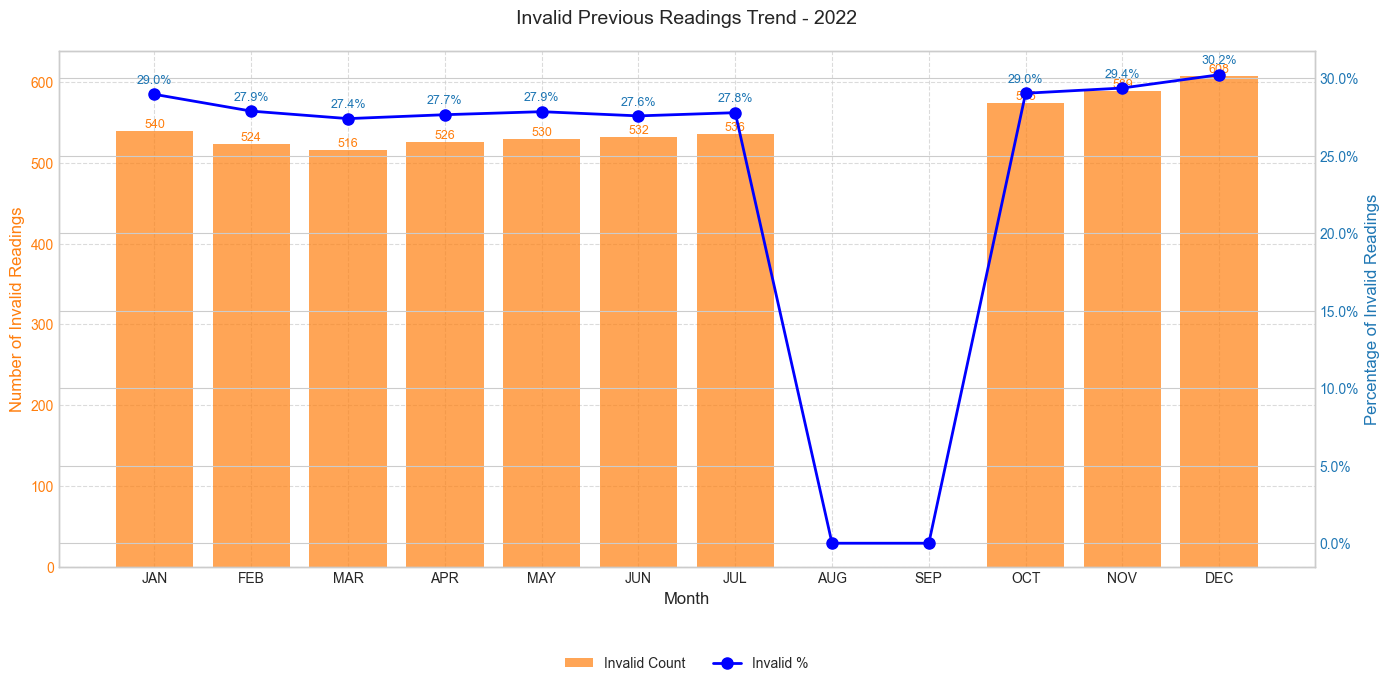

📊 Invalid Previous Analysis for 2022 (Readings ≤ 0 or invalid)
Month  Total Readings  Invalid Count   Invalid %  Status
--------------------------------------------------------------------------------
JAN    1,864           540              28.97%    ❌
FEB    1,879           524              27.89%    ❌
MAR    1,883           516              27.40%    ❌
APR    1,902           526              27.66%    ❌
MAY    1,903           530              27.85%    ❌
JUN    1,929           532              27.58%    ❌
JUL    1,929           536              27.79%    ❌
AUG    0               0                 0.00%    ✅
SEP    0               0                 0.00%    ✅
OCT    1,980           575              29.04%    ❌
NOV    2,005           589              29.38%    ❌
DEC    2,011           608              30.23%    ❌

🔍 Sample of Invalid Readings:

📅 JAN 2022 - 540 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
6,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
9,500484,"Almodal, Erlinda",Alicante St.,NaN,DISC.,0.0,NaN
22,501663,"Altiche, Nenita",Alicante St.,NaN,DISC.,NaN,NaN
31,501020,"Barrun, Emilio",Alicante St.,NaN,DEFECT,0.0,60.0
39,500740,"Bartolata, Jose",Alicante St.,NaN,DISC.,NaN,NaN



📅 FEB 2022 - 524 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
6,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
9,500484,"Almodal, Erlinda/Almodal, Judem",Alicante St.,NaN,NaN,0.0,NaN
22,501663,"Altiche, Nenita",Alicante St.,NaN,DISC.,NaN,NaN
31,501020,"Barrun, Emilio",Alicante St.,NaN,DEFECT,0.0,60.0
39,500740,"Bartolata, Jose",Alicante St.,NaN,DISC.,NaN,NaN



📅 MAR 2022 - 516 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
6,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
22,501663,"Altiche, Nenita",Alicante St.,NaN,DISC.,NaN,NaN
30,501020,"Barrun, Emilio",Alicante St.,NaN,DEFECT,0.0,60.0
38,500740,"Bartolata, Jose",Alicante St.,NaN,DISC.,NaN,NaN
42,500940,"Bartolay, Democrito",Alicante St.,NaN,DISC.,NaN,NaN



📅 APR 2022 - 526 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
6,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
10,500739,"Almodal, Jolly",Alicante St.,NaN,DEFECT,0.0,60.0
18,501028,"Almoradie, Marites",Alicante St.,NaN,2552,0.0,60.0
22,501663,"Altiche, Nenita",Alicante St.,NaN,DISC.,NaN,NaN
38,500740,"Bartolata, Jose",Alicante St.,NaN,DISC.,NaN,NaN



📅 MAY 2022 - 530 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
6,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
10,500739,"Almodal, Jolly",Alicante St.,NaN,DEFECT,0.0,60.0
22,501663,"Altiche, Nenita",Alicante St.,NaN,DISC.,NaN,NaN
38,500740,"Bartolata, Jose",Alicante St.,NaN,DISC.,NaN,NaN
42,500940,"Bartolay, Democrito",Alicante St.,NaN,DISC.,NaN,NaN



📅 JUN 2022 - 532 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
5,501542,"AlmiÃ±e, Filben",Alicante St.,NaN,DISC.,0.0,NaN
6,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
10,500739,"Almodal, Jolly",Alicante St.,NaN,DEFECT,0.0,60.0
13,501447,"Almodiel, Mary Grace",Alicante St.,NaN,DEFECT,0.0,60.0
21,500260,"Altiche, Antonio",Alicante St.,NaN,DEFECT,0.0,60.0



📅 JUL 2022 - 536 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
5,501542,"AlmiÃ±e, Filben",Alicante St.,NaN,DISC.,0.0,NaN
6,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
10,500739,"Almodal, Jolly",Alicante St.,NaN,DEFECT,0.0,60.0
13,501447,"Almodiel, Mary Grace",Alicante St.,NaN,DEFECT,0.0,60.0
21,500260,"Altiche, Antonio",Alicante St.,NaN,DEFECT,0.0,60.0



📅 OCT 2022 - 575 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
6,501542,"AlmiÃ±e, Filben",Alicante St.,NaN,DISC.,0.0,NaN
7,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
11,500739,"Almodal, Jolly",Alicante St.,NaN,DEFECT,0.0,60.0
13,501447,"Almodiel, Mary Grace",Alicante St.,NaN,DEFECT,0.0,60.0
21,500260,"Altiche, Antonio",Alicante St.,NaN,DEFECT,0.0,60.0



📅 NOV 2022 - 589 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
6,501542,"AlmiÃ±e, Filben",Alicante St.,NaN,NaN,0.0,NaN
7,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,NaN,0.0,NaN
11,500739,"Almodal, Jolly",Alicante St.,NaN,DEFECT,0.0,60.0
13,501447,"Almodiel, Mary Grace",Alicante St.,NaN,745,0.0,60.0
21,500260,"Altiche, Antonio",Alicante St.,NaN,DEFECT,0.0,60.0



📅 DEC 2022 - 608 invalid readings:


,Control Number,Consumer's Name,Address,Previous,Present,Cons.,Amount
6,501542,"AlmiÃ±e, Filben",Alicante St.,NaN,DISC.,0.0,NaN
7,500431,"AlmiÃ±e, Franchie",Alicante St.,NaN,DISC.,0.0,NaN
11,500739,"Almodal, Jolly",Alicante St.,NaN,DEFECT,0.0,60.0
21,500260,"Altiche, Antonio",Alicante St.,NaN,DEFECT,0.0,60.0
22,501663,"Altiche, Nenita",Alicante St.,NaN,DISC.,NaN,NaN


In [52]:
def analyze_invalid_readings(year: str, column_name: str, limit: int = 5) -> None:
    """
    Analyze and visualize invalid readings (≤ 0) for a specified column across all months of a year.
    
    Args:
        year (str): The year to analyze (e.g., "2020")
        column_name (str): The column to check for invalid readings
        limit (int): Maximum number of invalid entries to display per month (default: 5)
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from collections import OrderedDict
    import matplotlib.ticker as mtick
    
    data_dir_path = f"../../dataset/raw/{year}/compiled/"
    
    # Dictionary to store results
    results = OrderedDict()
    months_order = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
                   'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    
    # Initialize results with all months
    for month in months_order:
        results[month] = {
            'total_readings': 0,
            'invalid_count': 0,
            'invalid_percent': 0,
            'sample': pd.DataFrame(),
            'has_invalid': False
        }
    
    # Get all monthly CSV files
    monthly_files = [f for f in os.listdir(data_dir_path) 
                    if f.endswith('.csv') and f.startswith(tuple([m.upper() for m in months_order]))]
    
    # Process each month
    for month_file in sorted(monthly_files):
        try:
            month = month_file[:3].upper()
            file_path = os.path.join(data_dir_path, month_file)
            
            # Read and process data
            df = pd.read_csv(file_path, encoding='latin-1')
            
            if column_name not in df.columns:
                print(f"⚠️  Column '{column_name}' not found in {month_file}")
                continue
                
            # Convert to numeric, coercing errors to NaN
            df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
            
            # Find invalid readings (≤ 0 or NaN)
            invalid_mask = (df[column_name] <= 0) | (df[column_name].isna())
            invalid_df = df[invalid_mask].copy()
            
            # Calculate statistics
            total_readings = len(df)
            invalid_count = len(invalid_df)
            invalid_percent = (invalid_count / total_readings * 100) if total_readings > 0 else 0
            
            # Store results
            results[month] = {
                'total_readings': total_readings,
                'invalid_count': invalid_count,
                'invalid_percent': invalid_percent,
                'sample': invalid_df.head(limit),
                'has_invalid': invalid_count > 0
            }
            
        except Exception as e:
            print(f"Error processing {month_file}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Prepare data for visualization
    months = list(results.keys())
    invalid_counts = [results[m]['invalid_count'] for m in months]
    invalid_percents = [results[m]['invalid_percent'] for m in months]
    
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Bar plot for invalid counts
    bars = ax1.bar(months, invalid_counts, color='#ff7f0e', alpha=0.7, label='Invalid Count')
    ax1.set_xlabel('Month', fontsize=12)
    ax1.set_ylabel('Number of Invalid Readings', color='#ff7f0e', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#ff7f0e')
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only label bars with height > 0
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=9, color='#ff7f0e')
    
    # Create secondary y-axis for percentage
    ax2 = ax1.twinx()
    line = ax2.plot(months, invalid_percents, 'b-', marker='o', 
                   linewidth=2, markersize=8, label='Invalid %')
    ax2.set_ylabel('Percentage of Invalid Readings', color='#1f77b4', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#1f77b4')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    
    # Add percentage labels on the line
    for x, y in zip(months, invalid_percents):
        if y > 0:  # Only label if percentage > 0
            ax2.text(x, y + 0.5, f'{y:.1f}%', 
                    ha='center', va='bottom', fontsize=9, color='#1f77b4')
    
    # Add title and grid
    plt.title(f'Invalid {column_name} Readings Trend - {year}', fontsize=14, pad=20)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
              bbox_to_anchor=(0.5, -0.15), ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    # Display the summary table
    print(f"📊 Invalid {column_name} Analysis for {year} (Readings ≤ 0 or invalid)")
    print("=" * 80)
    print(f"{'Month':<6} {'Total Readings':<15} {'Invalid Count':<15} {'Invalid %':<10} {'Status'}")
    print("-" * 80)
    
    any_invalid = False
    for month in months:
        data = results[month]
        status = "❌" if data['has_invalid'] else "✅"
        print(f"{month:<6} {data['total_readings']:<15,} {data['invalid_count']:<15,} {data['invalid_percent']:>6.2f}%    {status}")
        any_invalid = any_invalid or data['has_invalid']
    
    # Show detailed samples if any invalid readings found
    if any_invalid:
        print("\n🔍 Sample of Invalid Readings:")
        for month in months:
            data = results[month]
            if data['has_invalid'] and not data['sample'].empty:
                print(f"\n📅 {month} {year} - {data['invalid_count']:,} invalid readings:")
                display(data['sample'])
    else:
        print("\n✅ No invalid readings found in any month!")


analyze_invalid_readings(year="2022", column_name="Previous", limit=5)

# Address Assessment

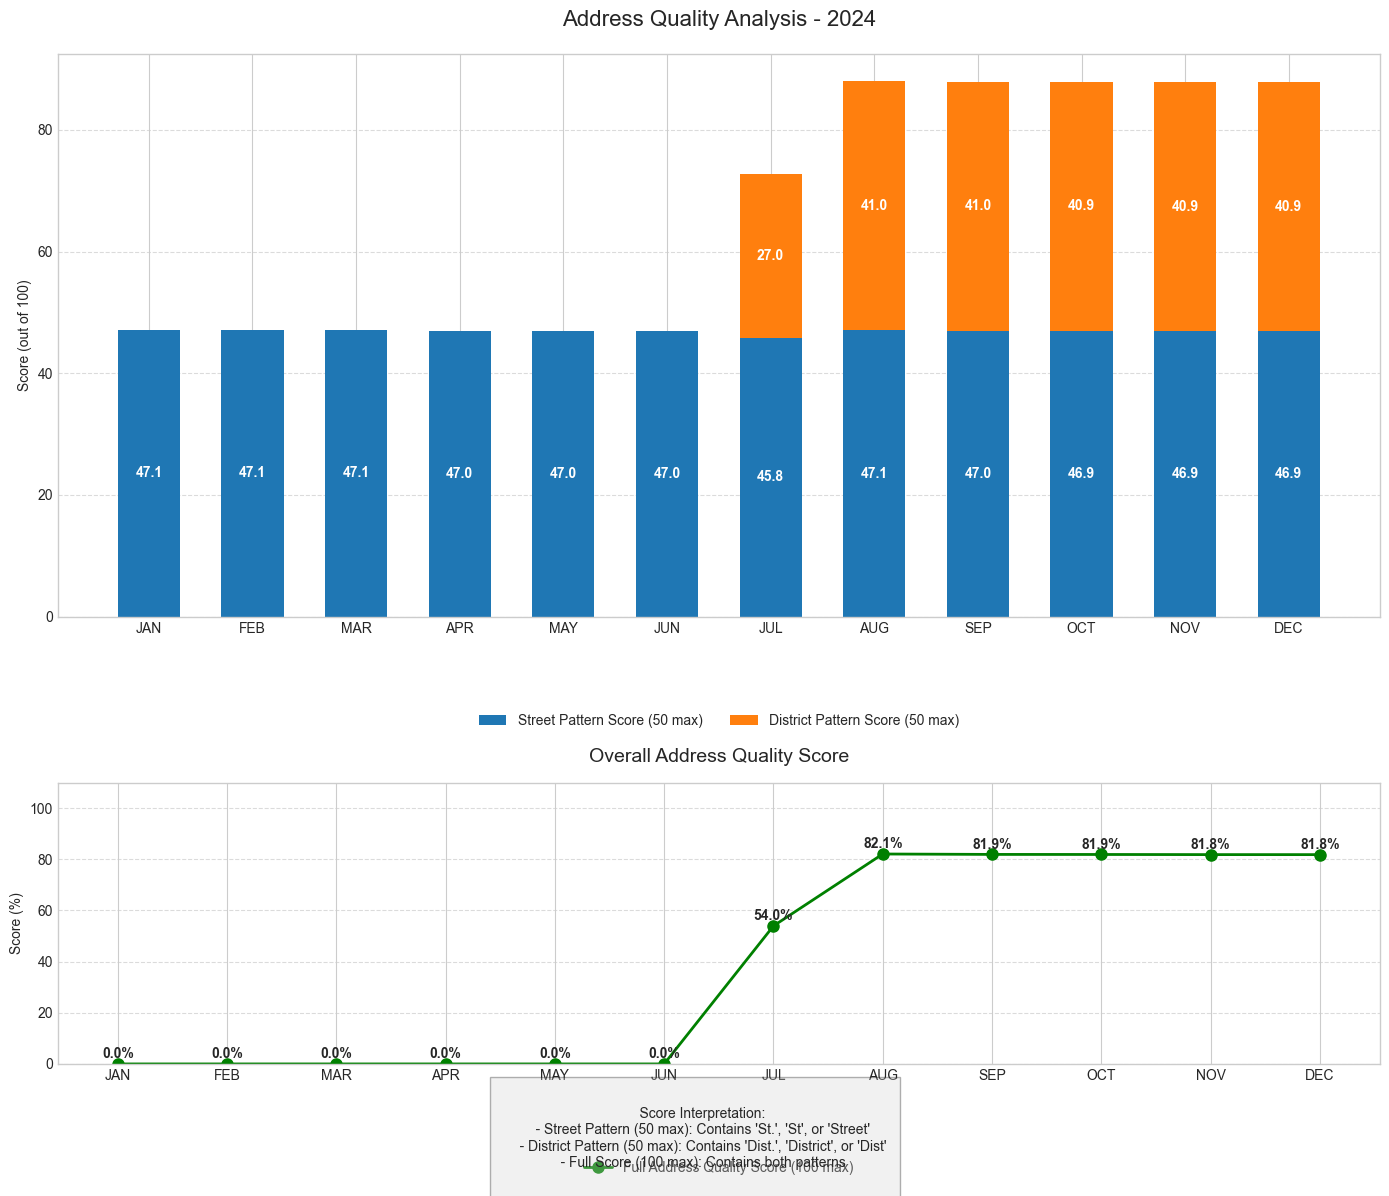

📊 Address Quality Analysis for 2024
Month  Total      Street Score    District Score  Full Score   Quality
--------------------------------------------------------------------------------
JAN    2,114      47.1            0.0             0.0          ❌ Poor
FEB    2,111      47.1            0.0             0.0          ❌ Poor
MAR    2,112      47.1            0.0             0.0          ❌ Poor
APR    2,128      47.0            0.0             0.0          ❌ Poor
MAY    2,130      47.0            0.0             0.0          ❌ Poor
JUN    2,130      47.0            0.0             0.0          ❌ Poor
JUL    2,122      45.8            27.0            54.0         ⚠️  Needs Review
AUG    2,136      47.1            41.0            82.1         ✅ Good
SEP    2,139      47.0            41.0            81.9         ✅ Good
OCT    2,147      46.9            40.9            81.9         ✅ Good
NOV    2,152      46.9            40.9            81.8         ✅ Good
DEC    2,151      46.9          

In [59]:
def analyze_address_quality(year: str) -> None:
    """
    Analyze and visualize address quality based on common patterns.
    
    Scores are calculated as:
    - 50 points if address contains 'St.', 'St', or 'Street'
    - Additional 50 points (total 100) if address contains 'Dist.', 'District', or 'Dist'
    
    Args:
        year (str): The year to analyze (e.g., "2020")
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import OrderedDict
    import re
    
    data_dir_path = f"../../dataset/raw/{year}/compiled/"
    months_order = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
                   'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    
    # Initialize results
    results = OrderedDict()
    for month in months_order:
        results[month] = {
            'total': 0,
            'st_score': 0,
            'dist_score': 0,
            'full_score': 0,
            'scores': []
        }
    
    # Process each month
    monthly_files = [f for f in os.listdir(data_dir_path) 
                    if f.endswith('.csv') and 
                    f[:3].upper() in months_order]
    
    for month_file in sorted(monthly_files):
        try:
            month = month_file[:3].upper()
            file_path = os.path.join(data_dir_path, month_file)
            
            # Read data
            df = pd.read_csv(file_path, encoding='latin-1')
            
            # Find address column
            address_col = next((col for col in df.columns 
                              if 'address' in col.lower()), None)
            
            if not address_col:
                print(f"⚠️  No address column found in {month_file}")
                continue
                
            # Convert to string and clean
            addresses = df[address_col].astype(str).str.strip()
            total = len(addresses)
            if total == 0:
                continue
                
            # Calculate scores
            has_st = addresses.str.contains(r'\b(?:St\.?|Street)\b', case=False, regex=True)
            has_dist = addresses.str.contains(r'\b(?:Dist\.?|District)\b', case=False, regex=True)
            
            st_score = (has_st.sum() / total) * 50
            dist_score = (has_dist.sum() / total) * 50
            full_score = ((has_st & has_dist).sum() / total) * 100
            
            # Store results
            results[month] = {
                'total': total,
                'st_score': st_score,
                'dist_score': dist_score,
                'full_score': full_score,
                'scores': [st_score, dist_score, full_score]
            }
            
        except Exception as e:
            print(f"Error processing {month_file}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Prepare data for visualization
    months = list(results.keys())
    st_scores = [results[m]['st_score'] for m in months]
    dist_scores = [results[m]['dist_score'] for m in months]
    full_scores = [results[m]['full_score'] for m in months]
    
    # Create figure and axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})
    
    # Stacked bar chart
    width = 0.6
    x = np.arange(len(months))
    
    p1 = ax1.bar(x, st_scores, width, label='Street Pattern Score (50 max)')
    p2 = ax1.bar(x, dist_scores, width, bottom=st_scores, 
                label='District Pattern Score (50 max)')
    
    # Line plot for full score
    ax2.plot(months, full_scores, 'g-o', linewidth=2, markersize=8, 
            label='Full Address Quality Score (100 max)')
    
    # Add value labels
    for i, (s1, s2, f) in enumerate(zip(st_scores, dist_scores, full_scores)):
        # Stacked bar labels
        if s1 > 0:
            ax1.text(i, s1/2, f'{s1:.1f}', ha='center', va='center', color='white', fontweight='bold')
        if s2 > 0:
            ax1.text(i, s1 + s2/2, f'{s2:.1f}', ha='center', va='center', color='white', fontweight='bold')
        
        # Line plot labels
        ax2.text(i, f + 1, f'{f:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Customize first subplot
    ax1.set_title(f'Address Quality Analysis - {year}', fontsize=16, pad=20)
    ax1.set_ylabel('Score (out of 100)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(months)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Customize second subplot
    ax2.set_title('Overall Address Quality Score', fontsize=14, pad=15)
    ax2.set_ylabel('Score (%)')
    ax2.set_ylim(0, 110)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
    
    # Add score interpretation
    interpretation = """
    Score Interpretation:
    - Street Pattern (50 max): Contains 'St.', 'St', or 'Street'
    - District Pattern (50 max): Contains 'Dist.', 'District', or 'Dist'
    - Full Score (100 max): Contains both patterns
    """
    plt.figtext(0.5, 0.01, interpretation, ha='center', fontsize=10, 
                bbox={'facecolor': 'lightgray', 'alpha': 0.3, 'pad': 10})
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print(f"📊 Address Quality Analysis for {year}")
    print("=" * 80)
    print(f"{'Month':<6} {'Total':<10} {'Street Score':<15} {'District Score':<15} {'Full Score':<12} {'Quality'}")
    print("-" * 80)
    
    for month in months:
        data = results[month]
        quality = "✅ Good" if data['full_score'] >= 80 else "⚠️  Needs Review" if data['full_score'] >= 50 else "❌ Poor"
        print(f"{month:<6} {data['total']:<10,} {data['st_score']:<15.1f} {data['dist_score']:<15.1f} {data['full_score']:<12.1f} {quality}")

analyze_address_quality(year="2024")

# Negative consumption difference anomalies

In [83]:
# Review of consumption difference
july_df = pd.read_csv("../../dataset/raw/2020/JUL2020.csv", encoding='latin-1')
oct_df = pd.read_csv("../../dataset/raw/2020/OCT2020.csv", encoding='latin-1')

july_df['Present'] = pd.to_numeric(july_df['Present'], errors='coerce')
oct_df['Present'] = pd.to_numeric(oct_df['Present'], errors='coerce')

july_mini_df = july_df[['Control Number', 'Consumer\'s Name', 'Previous', 'Present']]
oct_mini_df = oct_df[['Control Number', 'Consumer\'s Name', 'Previous', 'Present']]

merged_df = pd.merge(july_mini_df, oct_mini_df, on=['Control Number', 'Consumer\'s Name'], suffixes=('_july', '_oct'))

merged_df['Consumption Difference'] = pd.to_numeric(merged_df['Present_oct']) - pd.to_numeric(merged_df['Present_july'])
display(merged_df.head())

negative_df = merged_df[merged_df['Consumption Difference'] < 0]
print("Negative Consumption Difference Count: ", len(negative_df))
display(negative_df.head())


,Control Number,Consumer's Name,Previous_july,Present_july,Previous_oct,Present_oct,Consumption Difference
0,501549,"Albaño, Lilane",275,286.0,306,312.0,26.0
1,500750,"Aljecera, Marcelino",3077,3086.0,3110,3114.0,28.0
2,500990,"Almiñana, Irus",592,619.0,671,698.0,79.0
3,500505,"Almiñe, Edison",NaN,17.0,255,291.0,274.0
4,501542,"Almiñe, Filben",3369,3401.0,3480,3509.0,108.0


Negative Consumption Difference Count:  8


,Control Number,Consumer's Name,Previous_july,Present_july,Previous_oct,Present_oct,Consumption Difference
199,500587,"Espinosa, Jerol",3084,3084.0,36,50.0,-3034.0
325,501276,"Barrun, Normelita",426,426.0,34,65.0,-361.0
409,501462,"Rejuso, Rolando",999,999.0,21,27.0,-972.0
482,500114,"Labastida, Maricel",2838,2884.0,2857,2864.0,-20.0
770,501446,"Espinosa, Florence",4212,4418.0,NaN,176.0,-4242.0


# Anomalous bill trend

📊 Consumption Analysis: JUL 2020 vs OCT 2020
Total records compared: 1,154
Average consumption in JUL: 1602.97 units
Average consumption in OCT: 1651.67 units
Average change: 48.70 units

Change Categories:
Change_Category
Normal                  580
Significant Increase    567
Significant Decrease      7


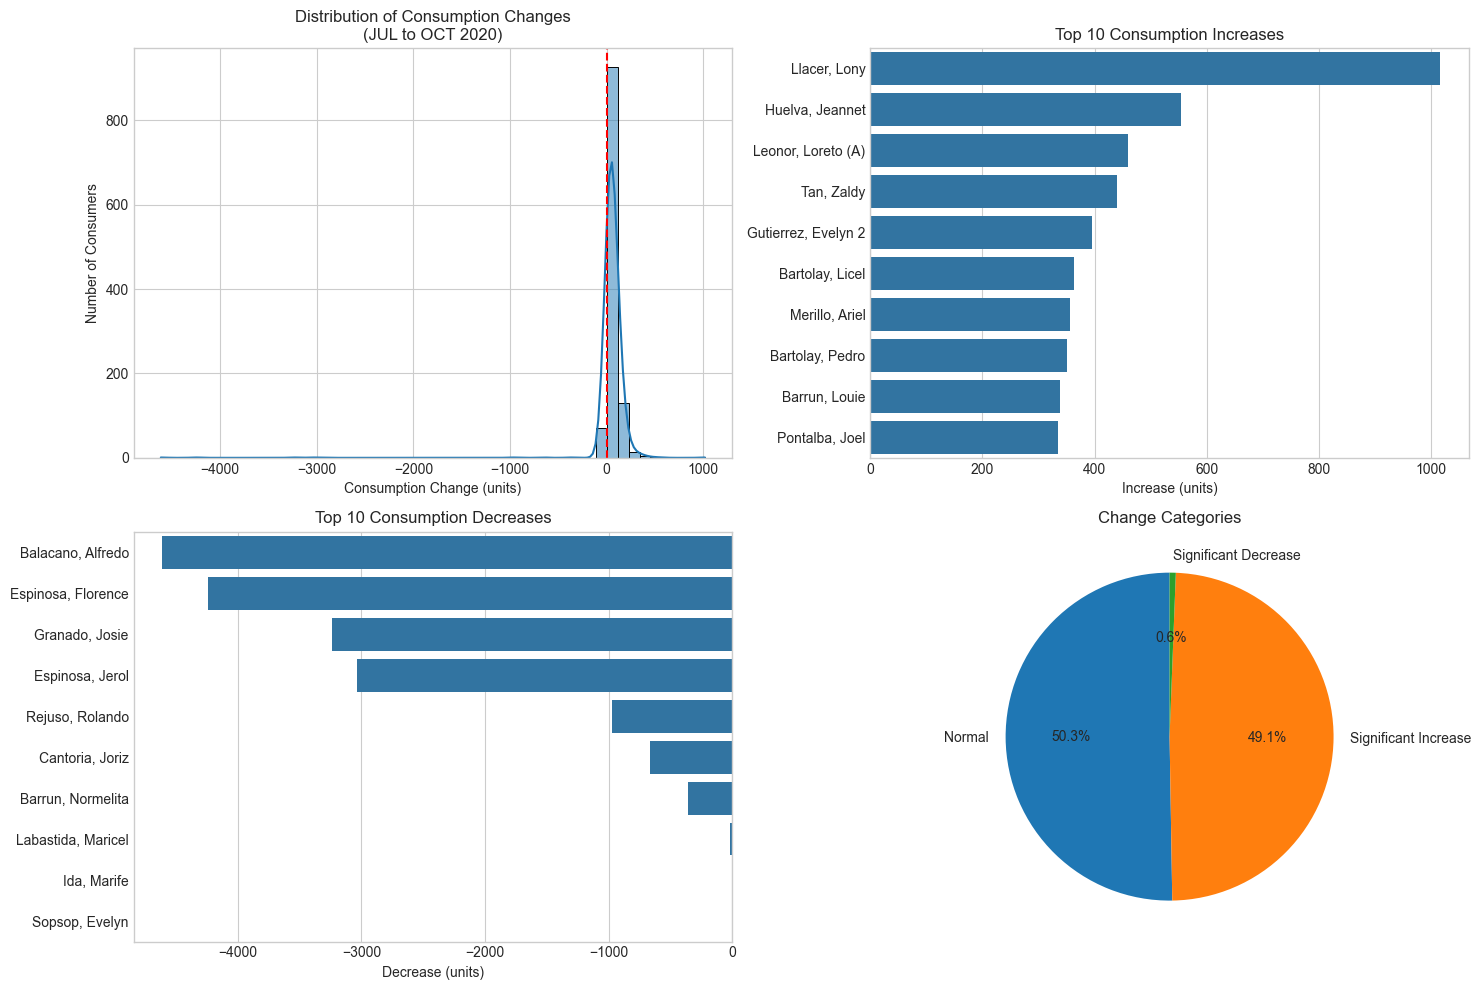

In [ ]:
def analyze_consumption_differences(year: str, month1: str, month2: str, 
                                  threshold: float = 0, top_n: int = 10) -> None:
    """
    Analyze and visualize consumption differences between two months.
    
    Args:
        year (str): The year to analyze (e.g., "2020")
        month1 (str): First month for comparison (e.g., "JUL")
        month2 (str): Second month for comparison (e.g., "OCT")
        threshold (float): Threshold for highlighting significant changes (default: 0)
        top_n (int): Number of top changes to display (default: 10)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pathlib import Path
    
    def load_monthly_data(year: str, month: str) -> pd.DataFrame:
        """Helper function to load and clean monthly data"""
        file_path = Path(f"../../dataset/raw/{year}/compiled/{month.upper()}_{year}.csv")
        try:
            df = pd.read_csv(file_path, encoding='latin-1')
            # Find relevant columns using flexible matching
            num_col = next((c for c in df.columns if c.lower() == 'present'), 'Present')
            prev_col = next((c for c in df.columns if c.lower() == 'previous'), 'Previous')
            name_col = next((c for c in df.columns if 'name' in c.lower()), "Consumer's Name")
            ctrl_col = next((c for c in df.columns if 'control' in c.lower()), 'Control Number')
            
            # Select and clean columns
            df = df[[ctrl_col, name_col, prev_col, num_col]].copy()
            df.columns = ['Control_Number', 'Name', 'Previous', 'Present']
            
            # Convert to numeric, handling errors
            for col in ['Previous', 'Present']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
            return df.dropna(subset=['Present'])
        except Exception as e:
            print(f"Error loading {month}{year}: {str(e)}")
            return pd.DataFrame()

    # Load and validate data
    df1 = load_monthly_data(year, month1)
    df2 = load_monthly_data(year, month2)
    
    if df1.empty or df2.empty:
        print("Error: Could not load data for one or both months")
        return
    
    # Merge the data
    merged = pd.merge(
        df1[['Control_Number', 'Name', 'Present']], 
        df2[['Control_Number', 'Present']], 
        on='Control_Number',
        suffixes=(f'_{month1.lower()}', f'_{month2.lower()}')
    )
    
    # Calculate differences
    present1 = f'Present_{month1.lower()}'
    present2 = f'Present_{month2.lower()}'
    merged['Consumption_Difference'] = merged[present2] - merged[present1]
    merged['Percentage_Change'] = (merged['Consumption_Difference'] / 
                                 merged[present1].replace(0, float('inf'))) * 100
    
    # Categorize changes
    def categorize_change(row):
        if row['Consumption_Difference'] < -threshold:
            return 'Significant Decrease'
        elif row['Consumption_Difference'] > threshold:
            return 'Significant Increase'
        return 'Normal'
    
    merged['Change_Category'] = merged.apply(categorize_change, axis=1)
    
    # Display summary statistics
    print(f"📊 Consumption Analysis: {month1} {year} vs {month2} {year}")
    print("=" * 80)
    print(f"Total records compared: {len(merged):,}")
    print(f"Average consumption in {month1}: {merged[present1].mean():.2f} units")
    print(f"Average consumption in {month2}: {merged[present2].mean():.2f} units")
    print(f"Average change: {merged['Consumption_Difference'].mean():.2f} units")
    print("\nChange Categories:")
    print(merged['Change_Category'].value_counts().to_string())
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Distribution of changes
    plt.subplot(2, 2, 1)
    sns.histplot(merged['Consumption_Difference'], bins=50, kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title(f'Distribution of Consumption Changes\n({month1} to {month2} {year})')
    plt.xlabel('Consumption Change (units)')
    plt.ylabel('Number of Consumers')
    
    # Plot 2: Top increases
    plt.subplot(2, 2, 2)
    top_increases = merged.nlargest(top_n, 'Consumption_Difference')
    sns.barplot(data=top_increases, y='Name', x='Consumption_Difference')
    plt.title(f'Top {top_n} Consumption Increases')
    plt.xlabel('Increase (units)')
    plt.ylabel('')
    
    # Plot 3: Top decreases
    plt.subplot(2, 2, 3)
    top_decreases = merged.nsmallest(top_n, 'Consumption_Difference')
    sns.barplot(data=top_decreases, y='Name', x='Consumption_Difference')
    plt.title(f'Top {top_n} Consumption Decreases')
    plt.xlabel('Decrease (units)')
    plt.ylabel('')
    
    # Plot 4: Change categories
    plt.subplot(2, 2, 4)
    category_counts = merged['Change_Category'].value_counts()
    plt.pie(category_counts, labels=category_counts.index, 
            autopct='%1.1f%%', startangle=90)
    plt.title('Change Categories')
    
    plt.tight_layout()
    plt.show()
    
    # Return the detailed results
    return merged.sort_values('Consumption_Difference', ascending=False)

results = analyze_consumption_differences(
    year="2020",
    month1="JUL",
    month2="OCT",
    threshold=50, 
    top_n=10     
)

# Order of Address

In [67]:
def display_unique_addresses(year: str) -> None:
    """
    Display all unique addresses from monthly water consumption data in the console.
    
    Args:
        year (str): The year to analyze (e.g., "2020")
    """
    import pandas as pd
    from pathlib import Path
    
    # Validate year input
    if not year.isdigit() or len(year) != 4:
        raise ValueError("Year must be a 4-digit string (e.g., '2020')")
    
    # Define months in chronological order
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
              'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    
    # Initialize an empty list to store DataFrames
    monthly_dfs = []
    
    print(f"🔍 Processing {len(months)} months of data for year {year}...")
    
    # Process each month's data
    for month in months:
        file_path = Path(f"../../dataset/raw/{year}/compiled/{month}_{year}.csv")
        try:
            # Read the CSV file
            df = pd.read_csv(file_path, encoding='latin-1', 
                           on_bad_lines='warn',
                           dtype={'Address': str})
            
            # Add month and year columns for tracking
            df['Month'] = month
            df['Year'] = year
            
            monthly_dfs.append(df)
            print(f"✓ Processed {month}{year}: {len(df):,} records")
            
        except FileNotFoundError:
            print(f"⚠️  File not found: {file_path}")
            continue
        except Exception as e:
            print(f"⚠️  Error processing {file_path}: {str(e)}")
            continue
    
    if not monthly_dfs:
        raise ValueError("No valid data files found for the specified year")
    
    # Combine all monthly data
    compiled_df = pd.concat(monthly_dfs, ignore_index=True)
    print(f"\n📊 Total records processed: {len(compiled_df):,}")
    
    # Get unique addresses (case-insensitive and strip whitespace)
    compiled_df['Address'] = compiled_df['Address'].str.strip().str.upper()
    unique_addresses = compiled_df['Address'].dropna().drop_duplicates().sort_values()
    
    print(f"\n📍 Found {len(unique_addresses):,} unique addresses")
    print("=" * 80)
    
    # Display all unique addresses with numbering
    for idx, address in enumerate(unique_addresses, 1):
        print(f"{idx:4}. {address}")
    
    print("=" * 80)
    print(f"✅ Displayed all {len(unique_addresses):,} unique addresses")

display_unique_addresses("2020")

🔍 Processing 12 months of data for year 2020...
✓ Processed JAN2020: 1,579 records
✓ Processed FEB2020: 1,624 records
✓ Processed MAR2020: 1,633 records
✓ Processed APR2020: 1,633 records
✓ Processed MAY2020: 1,637 records
✓ Processed JUN2020: 1,630 records
✓ Processed JUL2020: 1,630 records
✓ Processed AUG2020: 1,629 records
✓ Processed SEP2020: 1,695 records
✓ Processed OCT2020: 1,696 records
✓ Processed NOV2020: 1,696 records
⚠️  File not found: ..\..\dataset\raw\2020\compiled\DEC_2020.csv

📊 Total records processed: 18,082

📍 Found 24 unique addresses
   1. ALICANTE ST.
   2. ALMONTE ST.
   3. ALTAREJOS ST.
   4. AMICAN ST.
   5. BAILON ST.
   6. BALCAVEM ST.
   7. BALINTONG ST.
   8. BARSAGA ST.
   9. BARTOLABAC ST.
  10. BARTOLABAC ST. 1
  11. BARTOLAY ST.
  12. DON JUAN ST.
  13. ESPARRAGO ST.
  14. ESPINOSA ST.
  15. FABMAR ST.
  16. FLORES ST.
  17. GRAFILO ST.
  18. GUTIERREZ ST.
  19. JONES ST.
  20. LETADA ST.
  21. LIQUE ST.
  22. MOYOT ST.
  23. PURO, CALIPAT-AN
  24. VIL